In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

In [8]:
text = "hello how are you doing the cat said to the king and now the king was upset because he doesn't know what he doesn't know"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs.input_ids.to(device)
print(f"Number of input tokens: {input_ids.shape[-1]}")
# outputs = model(inputs.input_ids, past_key_values=torch.randn(6, 2, 1, 12, 20, 64))
# past_key_values = torch.randn(6, 2, 1, 12, 20, 64)
past_key_values = None
# outputs = model.forward(input_ids=inputs.input_ids, past_key_values=past_key_values, output_attentions=True)

Number of input tokens: 27


In [9]:
hms = [HopfieldMemory((1, 12, 20, 64), alpha=0.5, use_adaptive_alpha=False, opt='sgd', lr=1.0) for i in range(6)]
for hm in hms:
    hm.to(device)

In [10]:
ak = {'debug': True, 'layer': [], 'hms': hms}
akl = ak['layer']
outputs = model.forward(input_ids=input_ids, past_key_values=None, output_attentions=True, ak=ak)

In [11]:
A = akl[-1]['A']
A_sm = akl[-1]['A_sm']
Q, K, V = akl[-1]['QKV']

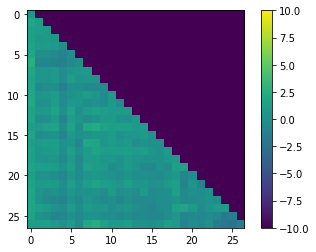

In [12]:
plt.imshow(to_np(A[0, 0]), vmin=-10, vmax=10)
plt.colorbar()

In [13]:
K.shape, hm.Km.shape

(torch.Size([1, 12, 27, 64]), torch.Size([1, 12, 20, 64]))

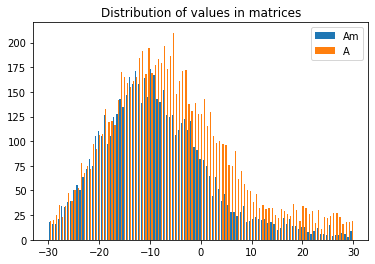

In [14]:
Km = torch.randn(1, 12, 20, 64).to(Q)
Km = (Km+K.mean(dim=-2, keepdim=True))*K.std(dim=-2, keepdim=True)
A = Q@K.transpose(-1, -2)
Am = Q@Km.transpose(-1, -2)
plt.title('Distribution of values in matrices')
plt.hist([to_np(Am.flatten()), to_np(A.flatten())], bins=np.linspace(-30, 30, 100), label=['Am', 'A'])
plt.legend()
plt.show()

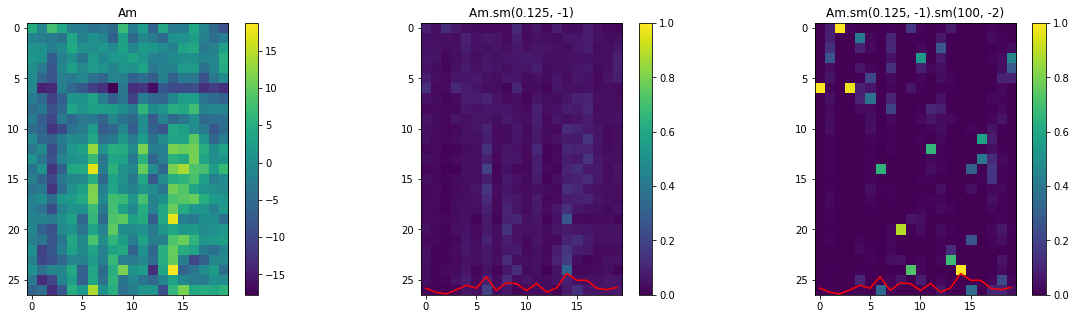

In [15]:
viz.viz_Am(Am[0,0], beta1=1/8, beta2=100)

  0%|          | 0/560 [00:00<?, ?it/s]

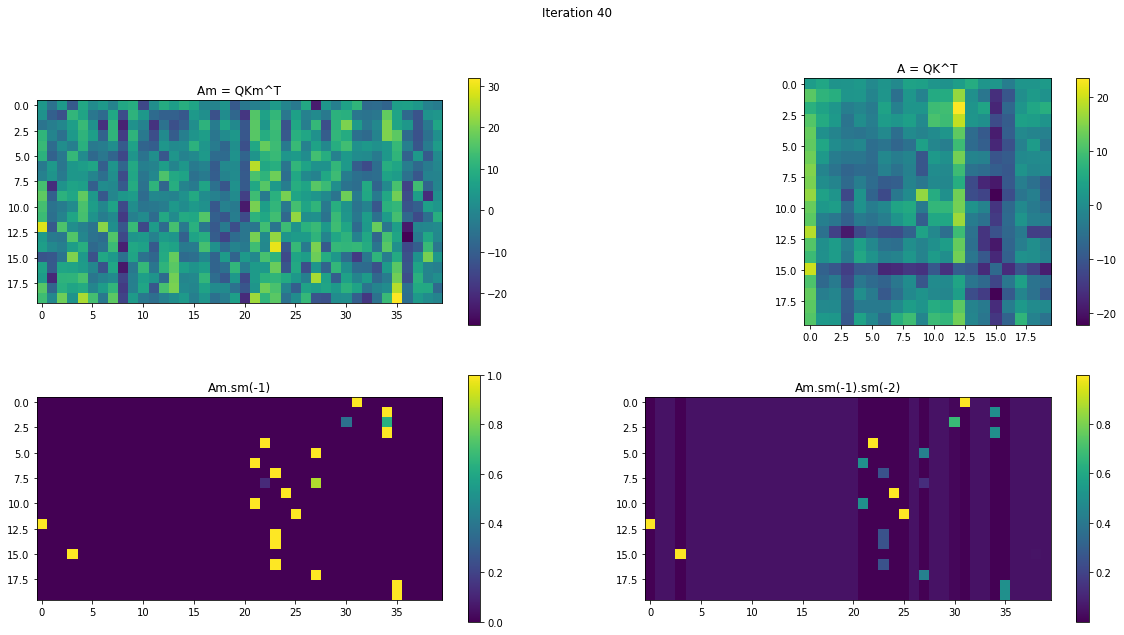

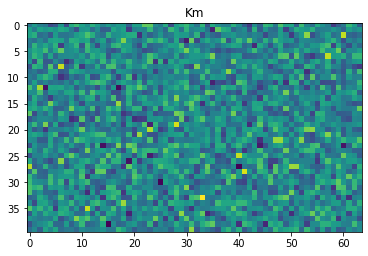

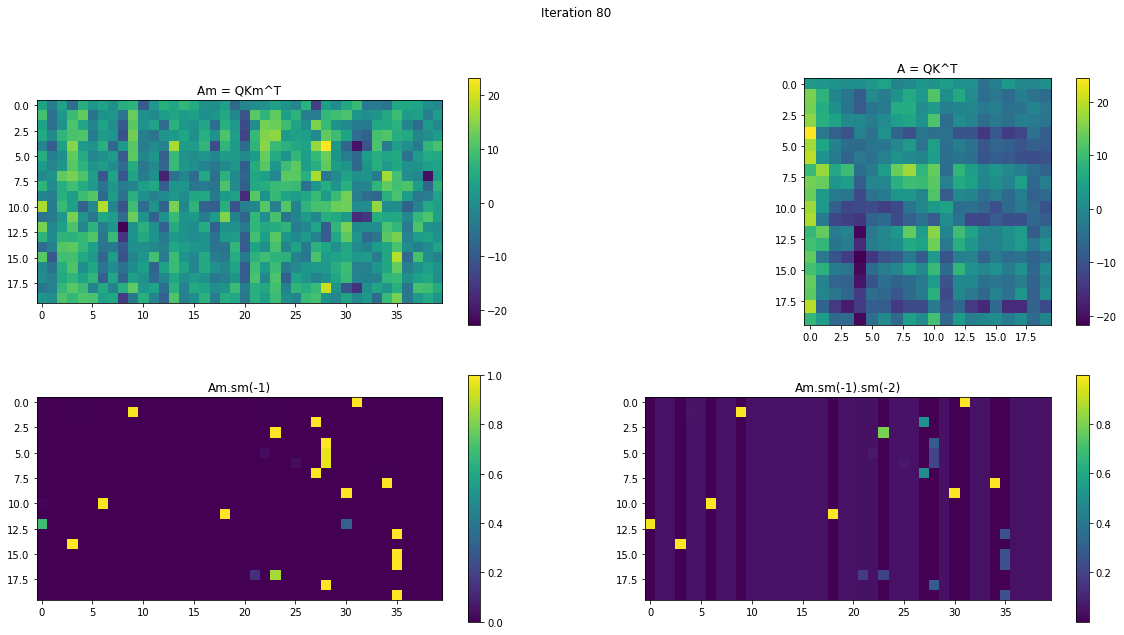

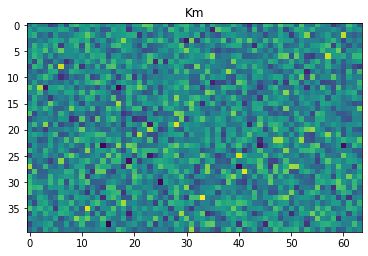

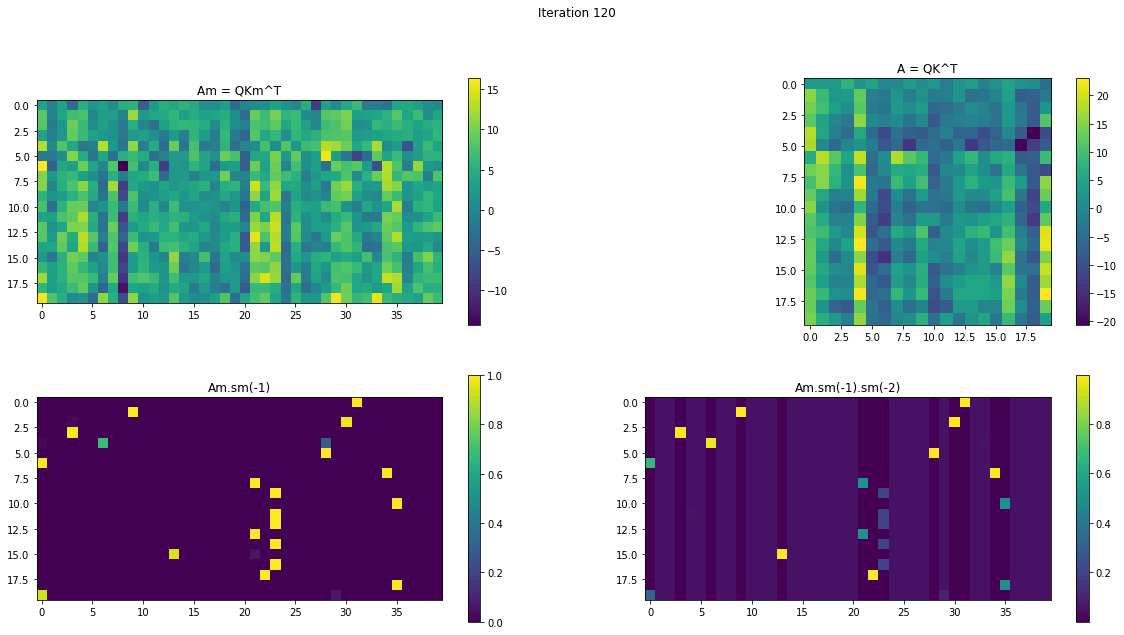

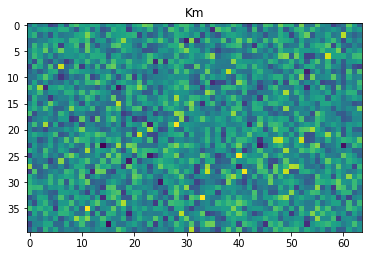

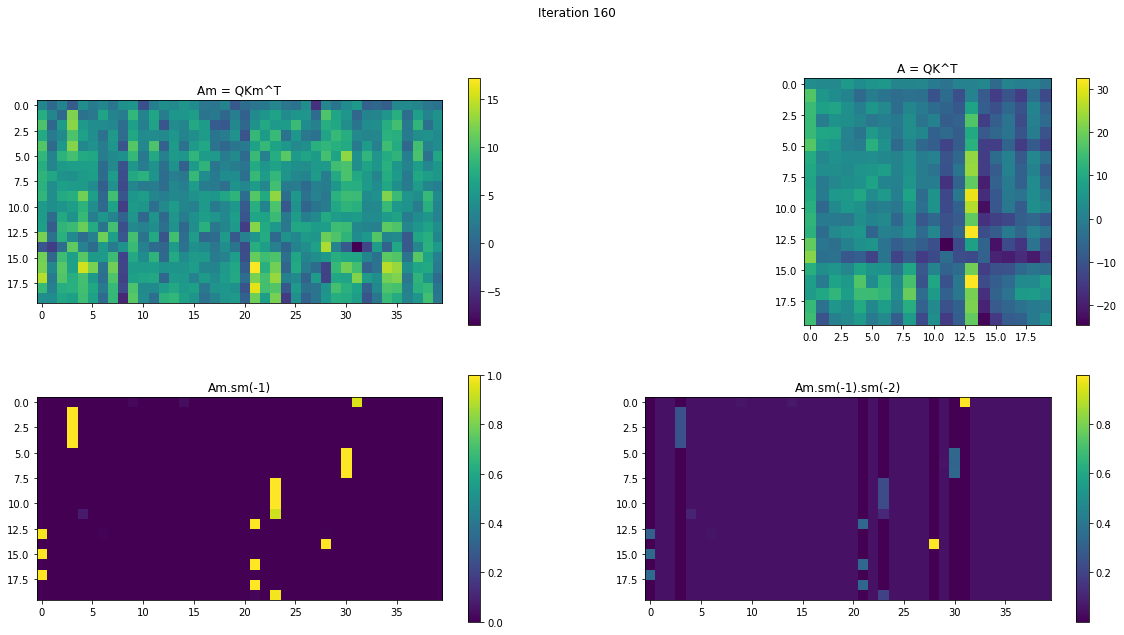

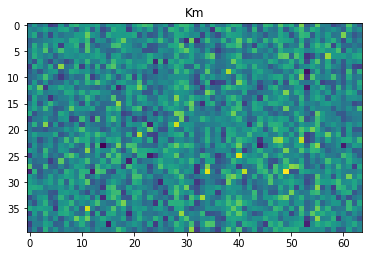

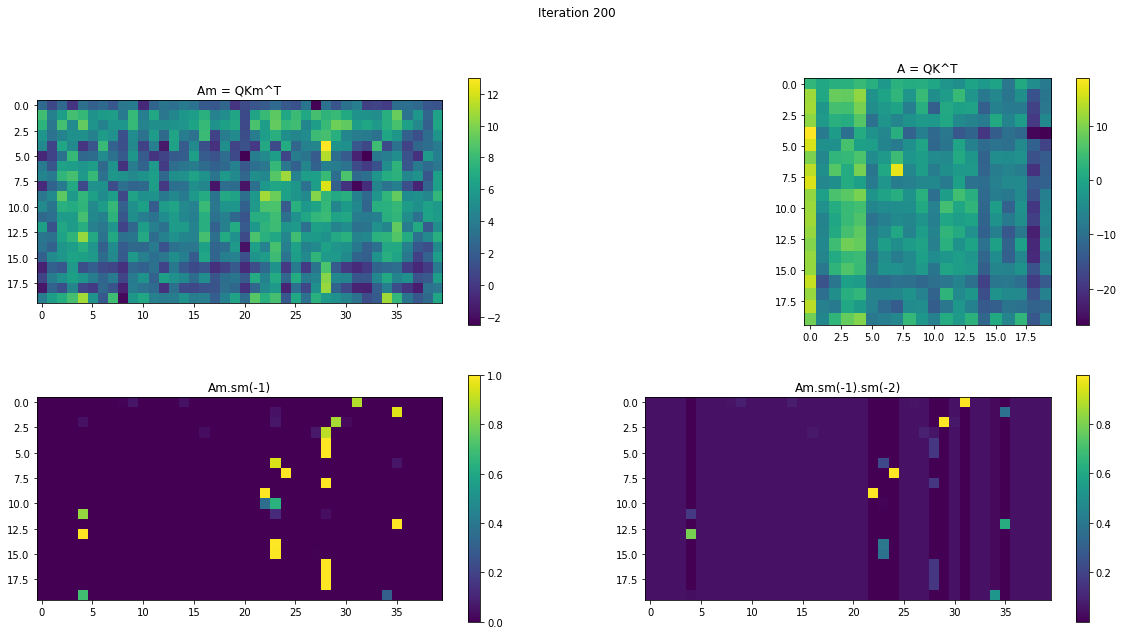

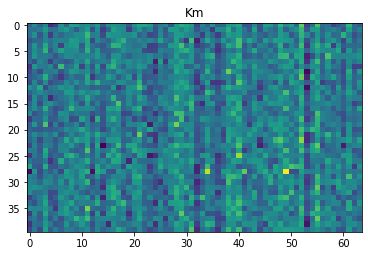

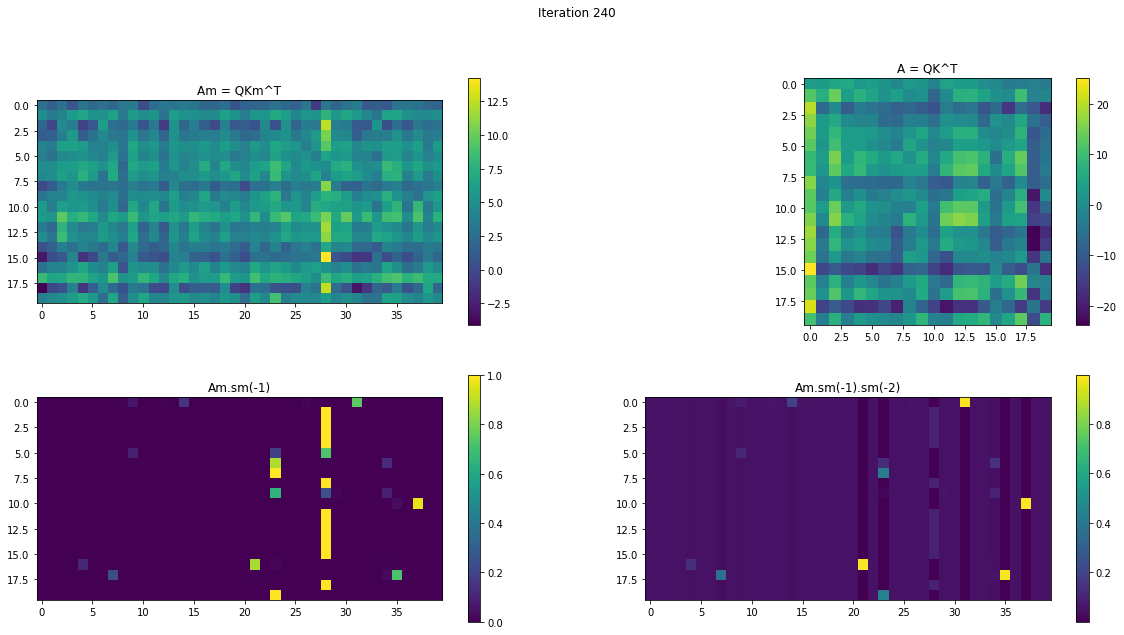

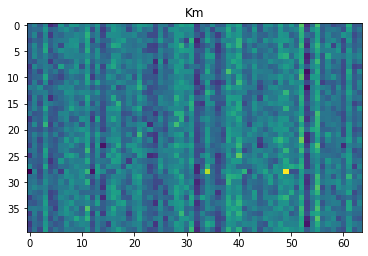

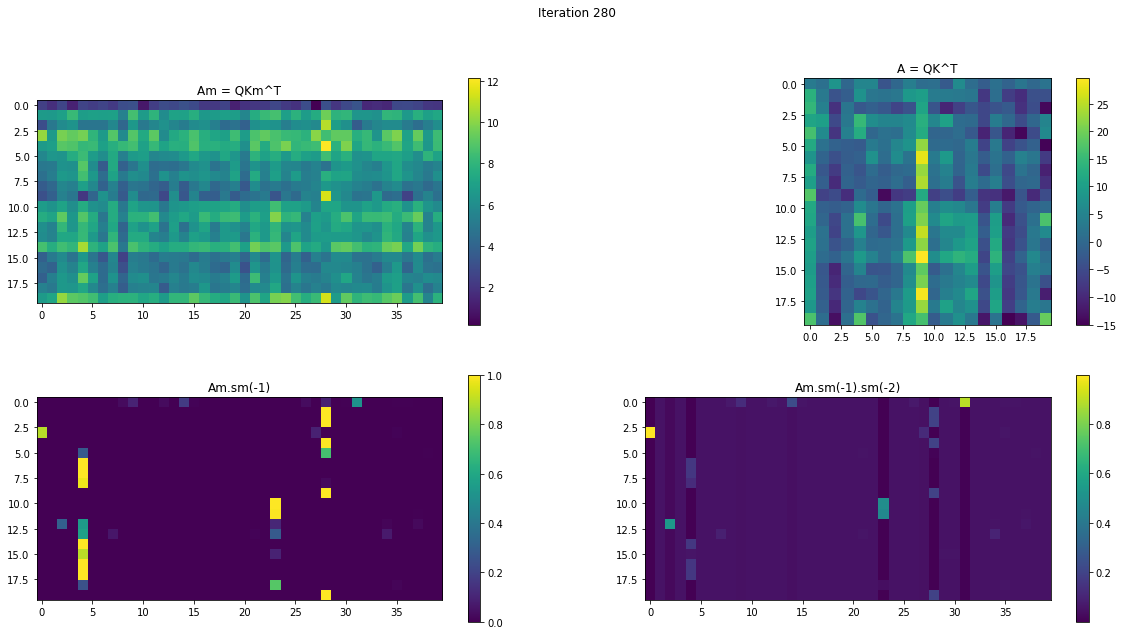

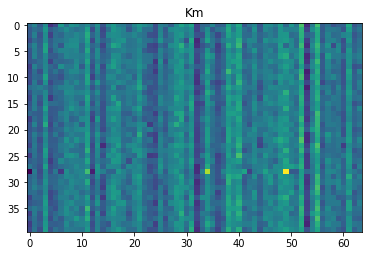

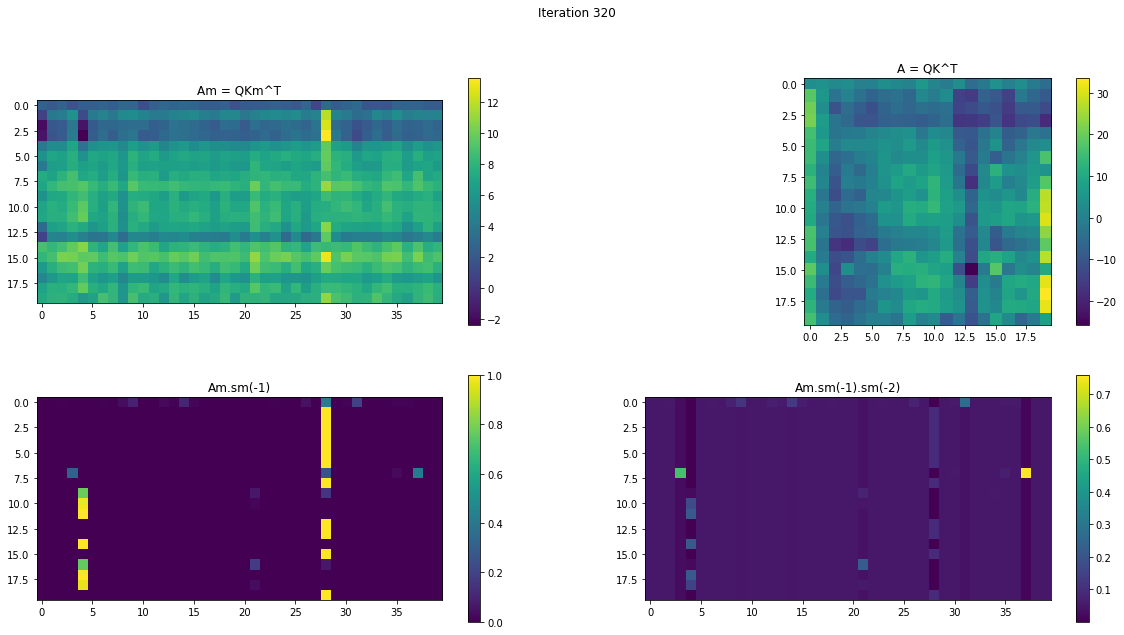

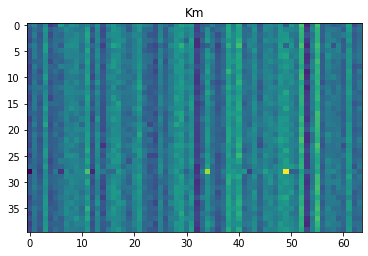

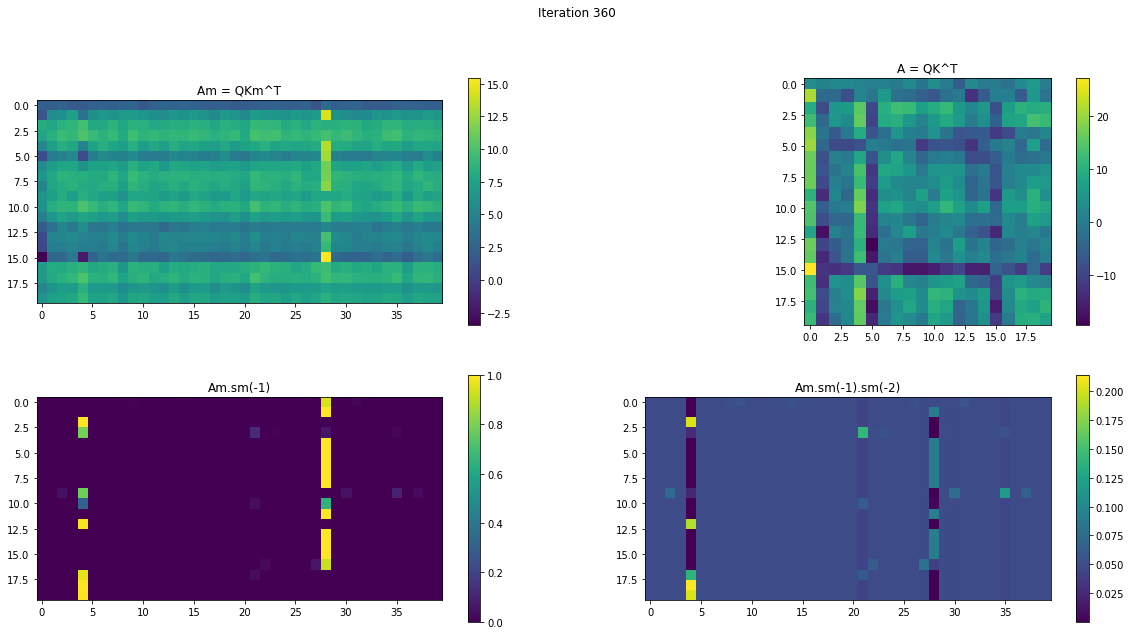

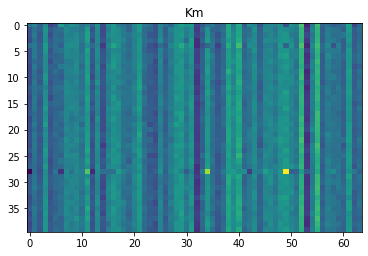

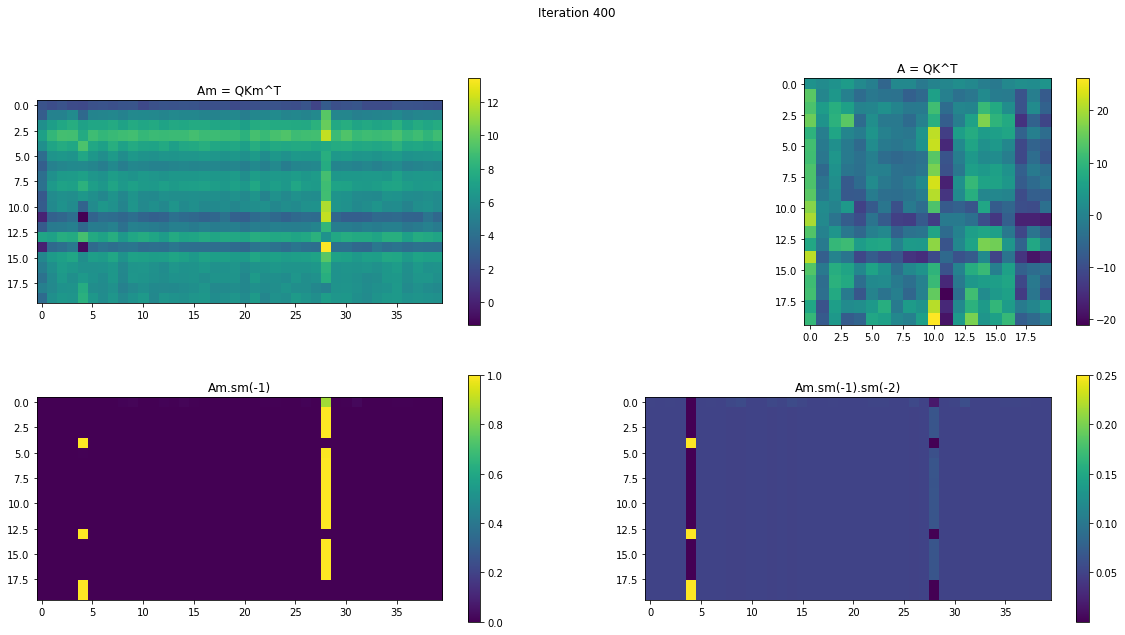

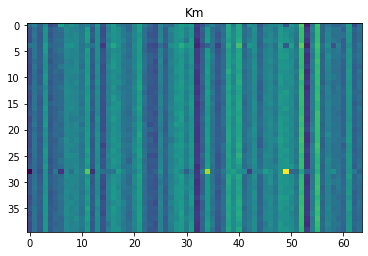

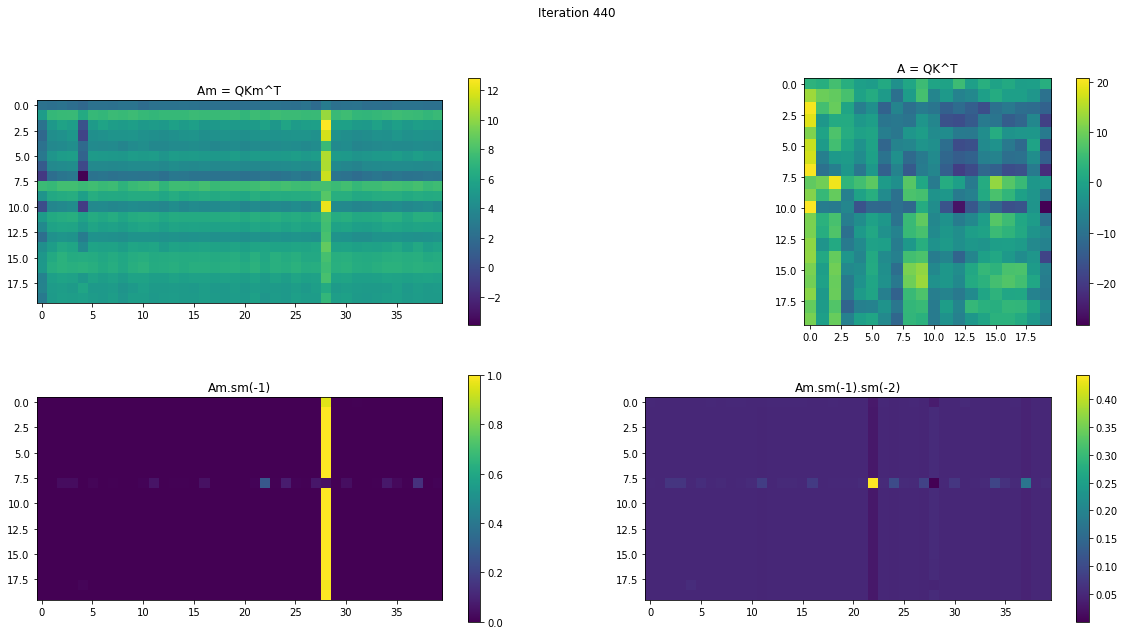

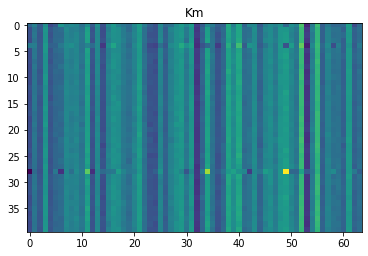

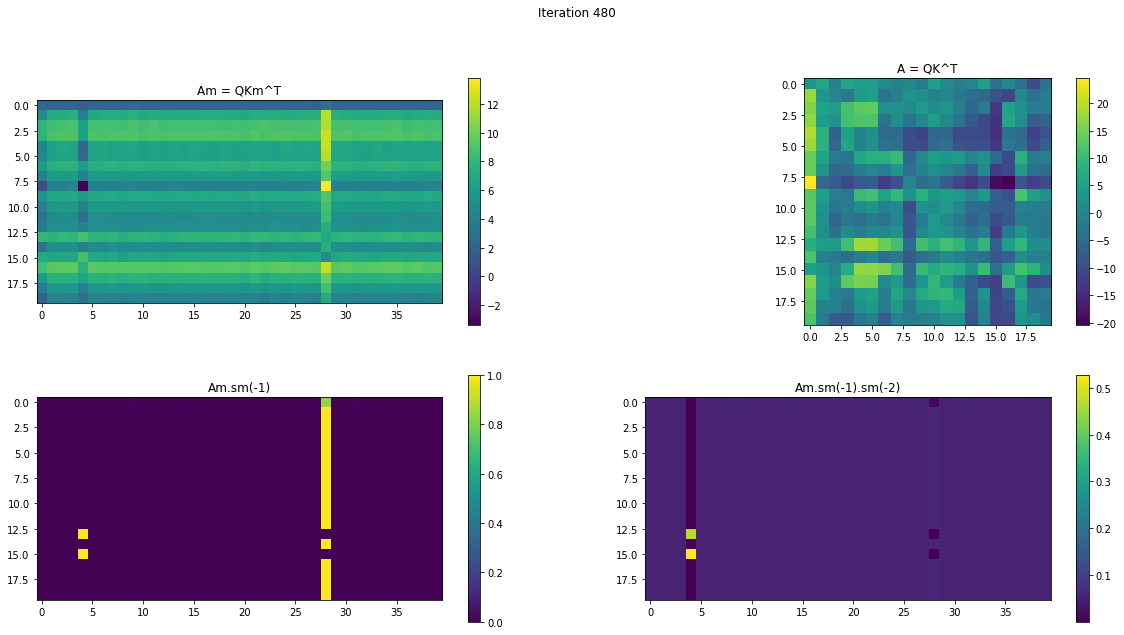

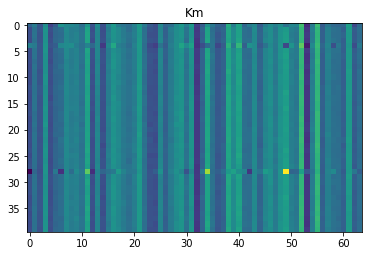

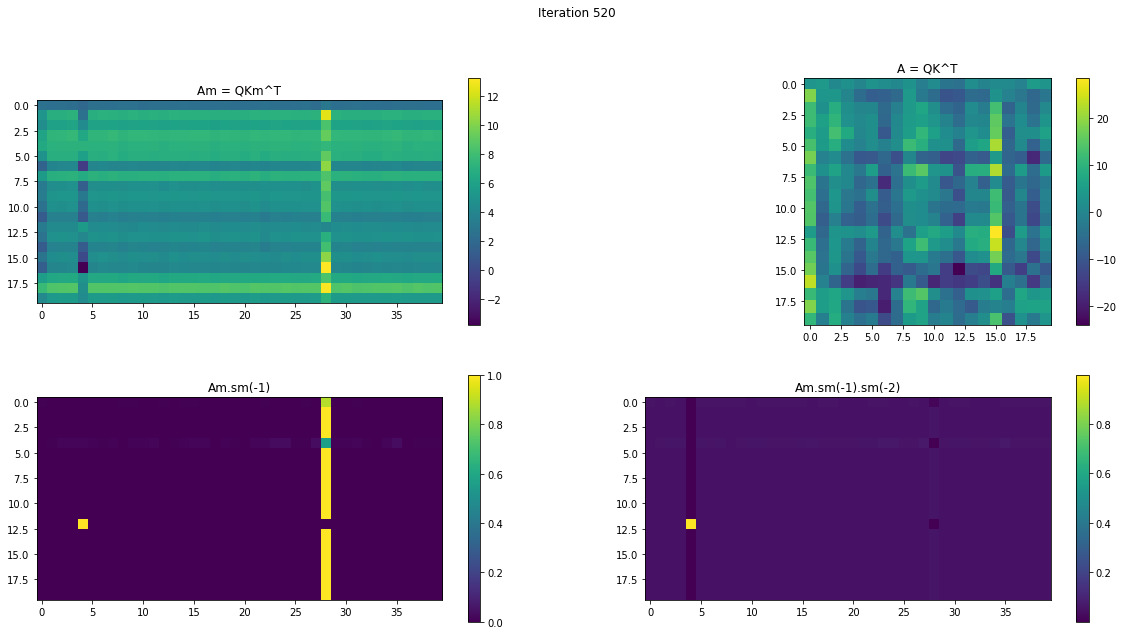

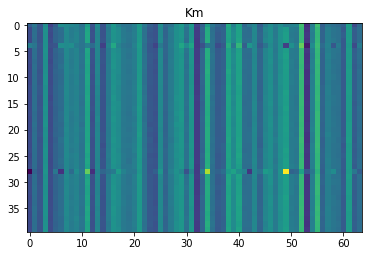

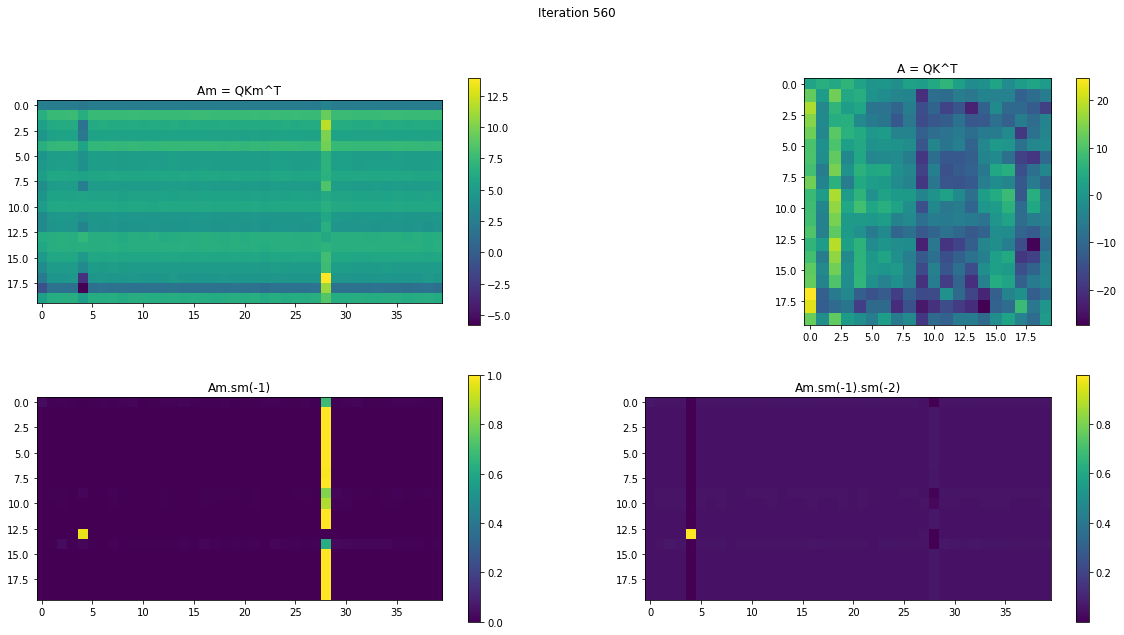

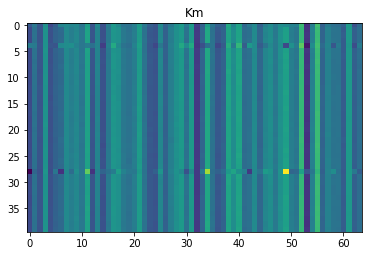

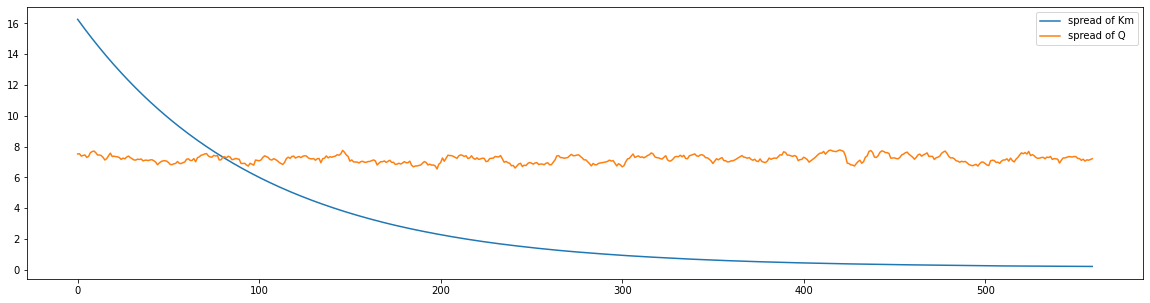

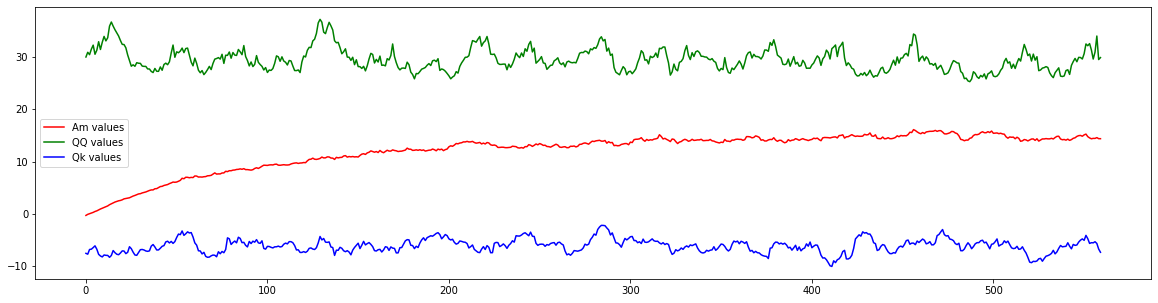

In [46]:
with open('book.txt') as f:
    text_book = f.read()

def experiment(tokenizer, model, text=None, context_length=100, stride=1, device='cpu', wandb=None):
    if text is None:
        text = text_book
        
    max_length = model.config.n_positions
    max_length = context_length
    
    all_tokens = tokenizer(text, return_tensors='pt')
    encodings = all_tokens
    
    model = model.to(device)
    
    beta1 = 10.
    beta2 = 10.
    hms = [HopfieldMemory((1, 12, 40, 64), alpha=0.01, use_adaptive_alpha=False, opt='sgd', lr=1.0) for i in range(6)]
    for hm in hms:
        hm.to(device)
        hm.reset(1.5)

    nlls = []
    # for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    graph = []
    Km_spread = []
    Q_spread = []
    # for i in tqdm(range(40, 300, stride)):
    for i in tqdm(range(40, 600, stride)):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        
        # print(begin_loc, end_loc, end_loc-begin_loc)
        with torch.no_grad():
            ak = {'debug': True, 'layer': [], 'hms': hms}
            akl = ak['layer']
            outputs = model(input_ids, labels=target_ids, ak=ak)
            neg_log_likelihood = outputs[0] * trg_len
            
            
            
            for layer_idx in range(6):
                hm = hms[layer_idx]
                Km = hm.Km
                A = akl[layer_idx]['A']
                A_sm = akl[layer_idx]['A_sm']
                O = akl[layer_idx]['O']
                Q, K, V = akl[layer_idx]['QKV']
                
                Am = Q@hm.Km.transpose(-1, -2)
                QQ = Q@Q.transpose(-1, -2)
                QK = Q@K.transpose(-1, -2)
                # print(Am.min().item(), Am.mean().item(), Am.max().item())
                
                # Km_target = Q
                Km_target = A_sm@K
                hm.set_target_with_data(Q=Km_target, O=O, dist_metric='dot', 
                                        beta1=beta1, beta2=beta2 , beta3=None)
                hm.step()
            
            if i%10==0 and False:
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(to_np(Am[0,0, :, :])); plt.colorbar()
                plt.subplot(132)
                a = Am[0,0, :, :]
                b = (beta1*a).softmax(dim=-1)
                plt.imshow(to_np(b)); plt.colorbar()
                plt.subplot(133)
                c = (beta2*(beta1*a).softmax(dim=-1)).softmax(dim=-2)
                plt.imshow(to_np(c)); plt.colorbar()
                # plt.imshow(to_np(hm.Km[0,0, :, :]))
                plt.show()
            # if i>0 and i%200==0:
                # break
                
            a = (hm.Km[:, :, None, :, :]-hm.Km[:, :, :, None, :]).norm(dim=-1)
            Km_spread.append(a.mean().item())
            a = (Q[:, :, None, :, :]-Q[:, :, :, None, :]).norm(dim=-1)
            Q_spread.append(a.mean().item())
            
            graph.append([
                [Am.min().item(), QQ.min().item(), QK.min().item()],
                [Am.mean().item(), QQ.mean().item(), QK.mean().item()],
                [Am.max().item(), QQ.max().item(), QK.max().item()],
            ])
            

        if not torch.isnan(neg_log_likelihood):
            nlls.append(neg_log_likelihood)
        else:
            print('Found NaN value')
            
        if i%40==0:
            plt.figure(figsize=(20,10))
            plt.suptitle(f'Iteration {i}')
            plt.subplot(221); plt.title('Am = QKm^T')
            plt.imshow(to_np(Am[0,0])); plt.colorbar()
            plt.subplot(222); plt.title('A = QK^T')
            plt.imshow(to_np(QK[0,0])); plt.colorbar()

            plt.subplot(223); plt.title('Am.sm(-1)')
            plt.imshow(to_np((beta1*Am[0,0]).softmax(dim=-1))); plt.colorbar()
            plt.subplot(224); plt.title('Am.sm(-1).sm(-2)')
            plt.imshow(to_np((beta2*(beta1*Am[0,0]).softmax(dim=-1)).softmax(dim=-2))); plt.colorbar()
            plt.show()
            
            plt.title('Km');
            plt.imshow(to_np(Km[0,0]))
            plt.show()
            
    plt.figure(figsize=(20,5))
    plt.plot(np.array(Km_spread), label='spread of Km')
    plt.plot(np.array(Q_spread), label='spread of Q')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,5))
    graph = np.array(graph).swapaxes(-1, -2)
    plt.plot(graph[:, 0, 1], c='r', label='Am values')
    plt.plot(graph[:, 1, 1], c='g', label='QQ values')
    plt.plot(graph[:, 2, 1], c='b', label='Qk values')
    # plt.plot(np.array(graph), label=['Am', 'QQ', 'QK'])
    plt.legend()
    plt.show()
    

torch.manual_seed(0)
experiment(tokenizer, model, context_length=20, device=device)

In [16]:
Q = Q[0, 0]

In [17]:
hm = HopfieldMemory((40, 64), alpha=0.4, use_adaptive_alpha=False, opt='sgd', lr=1.0).to(Q.device)
hm.reset(1.)
hm.Km.data[:, :] = hm.Km.data[:, :]*Q.std(dim=0)+Q.mean(dim=0)

In [18]:
a = hm.Km.data.clone()
print((a[:, None, :] - a[None, :, :]).norm(dim=-1).mean())
a = Q
print((a[:, None, :] - a[None, :, :]).norm(dim=-1).mean())

tensor(7.0583, device='cuda:0')
tensor(6.7464, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 0/500 [00:00<?, ?it/s]

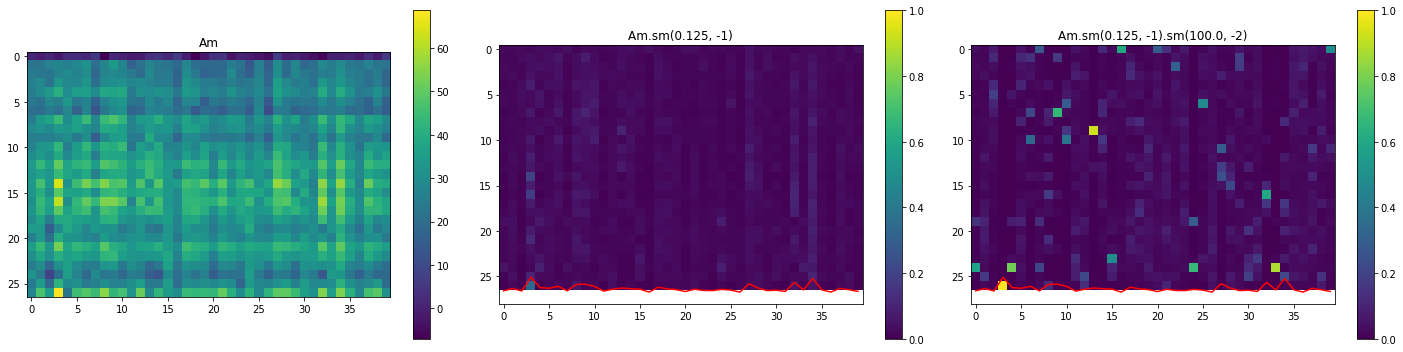

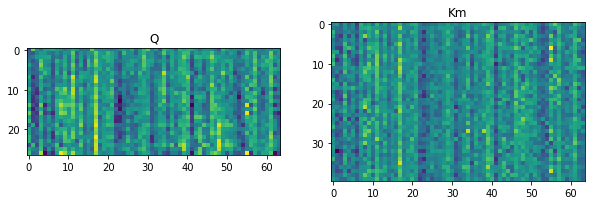

<Figure size 432x288 with 0 Axes>

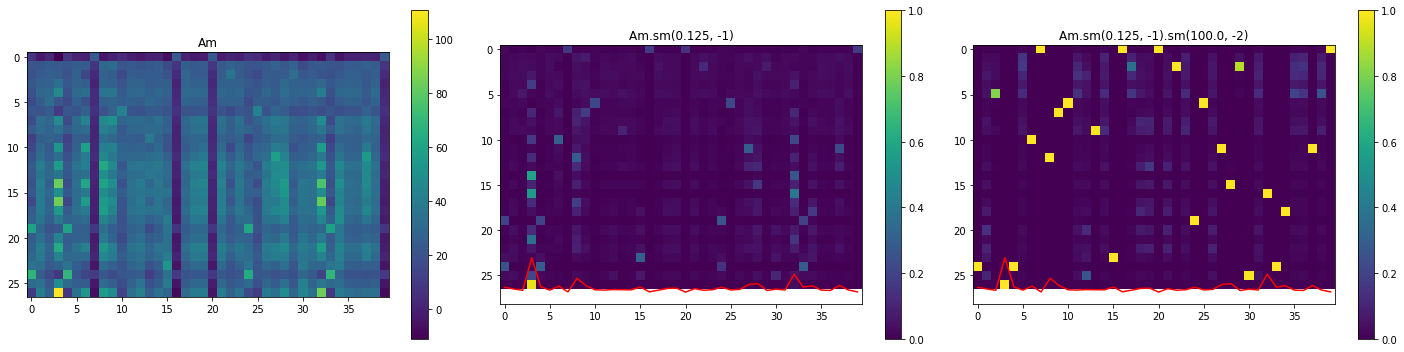

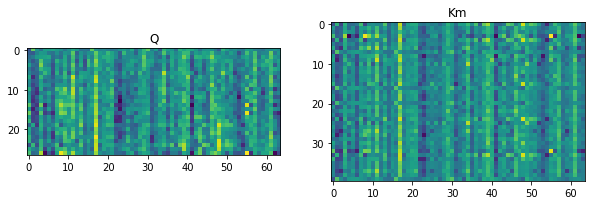

<Figure size 432x288 with 0 Axes>

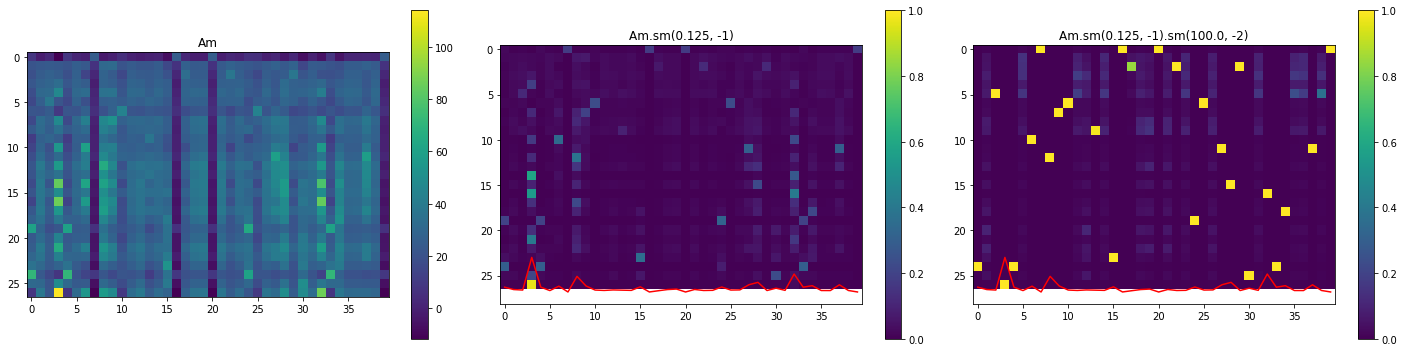

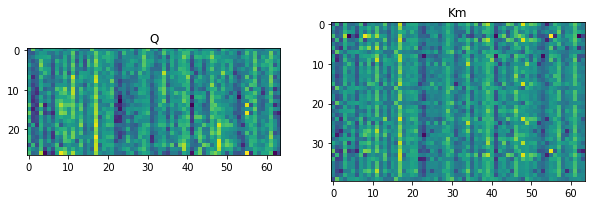

<Figure size 432x288 with 0 Axes>

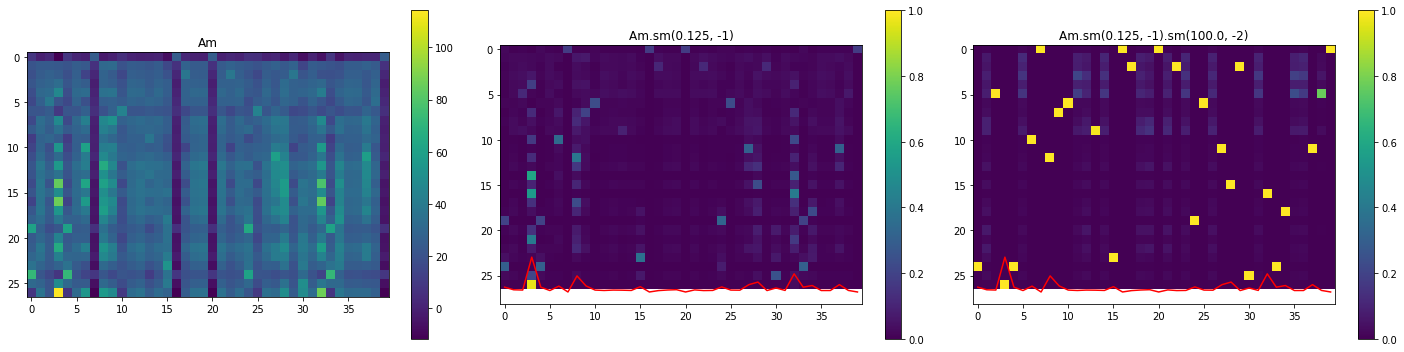

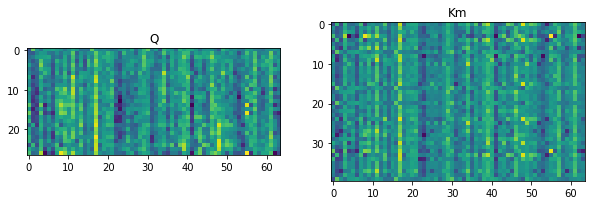

<Figure size 432x288 with 0 Axes>

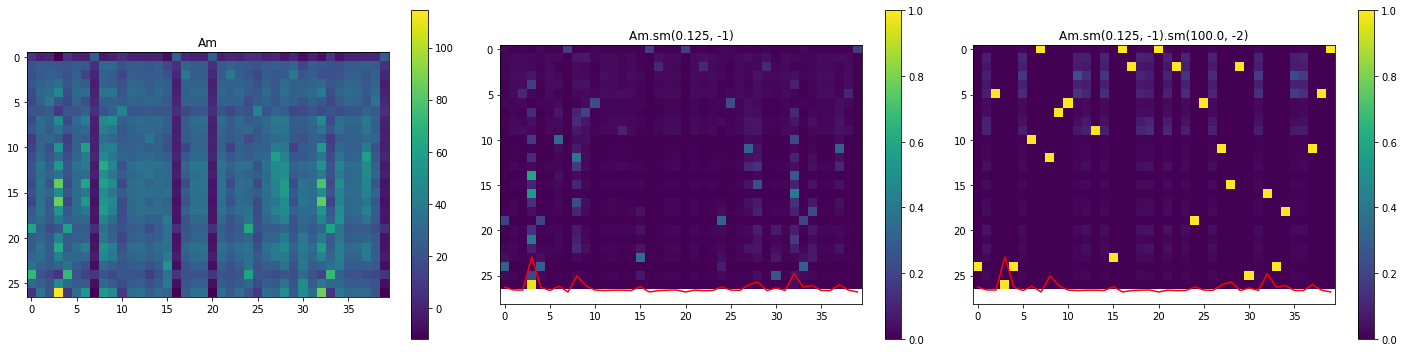

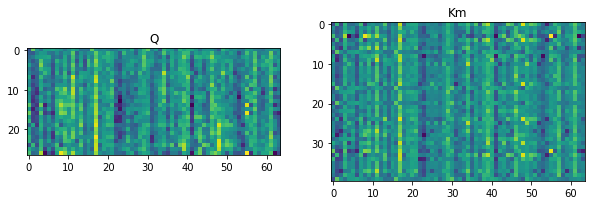

<Figure size 432x288 with 0 Axes>

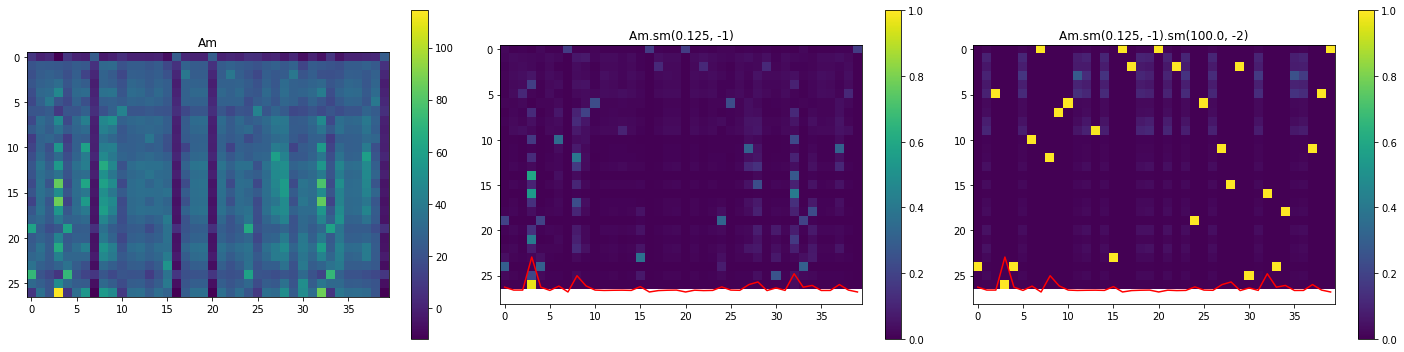

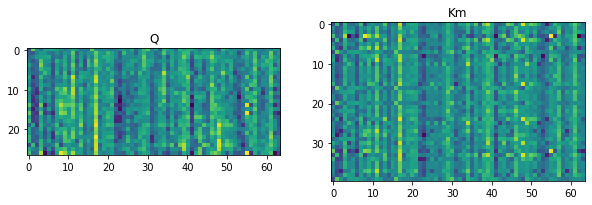

<Figure size 432x288 with 0 Axes>

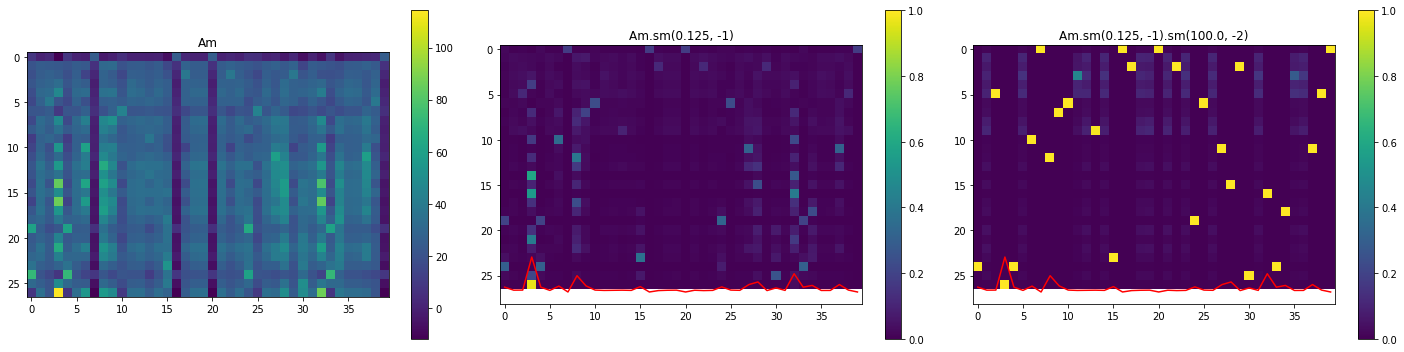

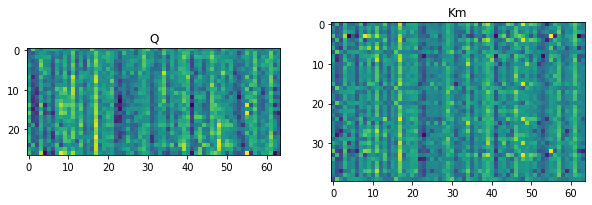

<Figure size 432x288 with 0 Axes>

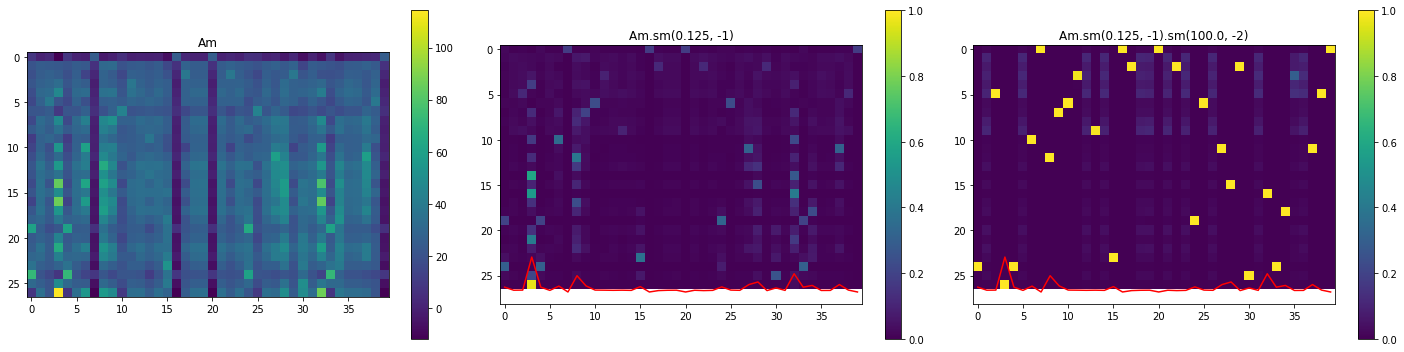

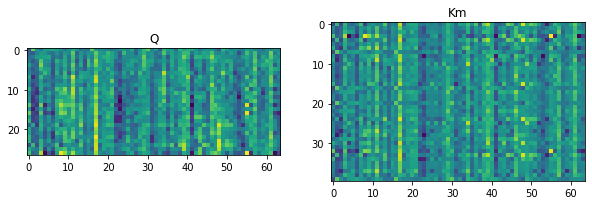

<Figure size 432x288 with 0 Axes>

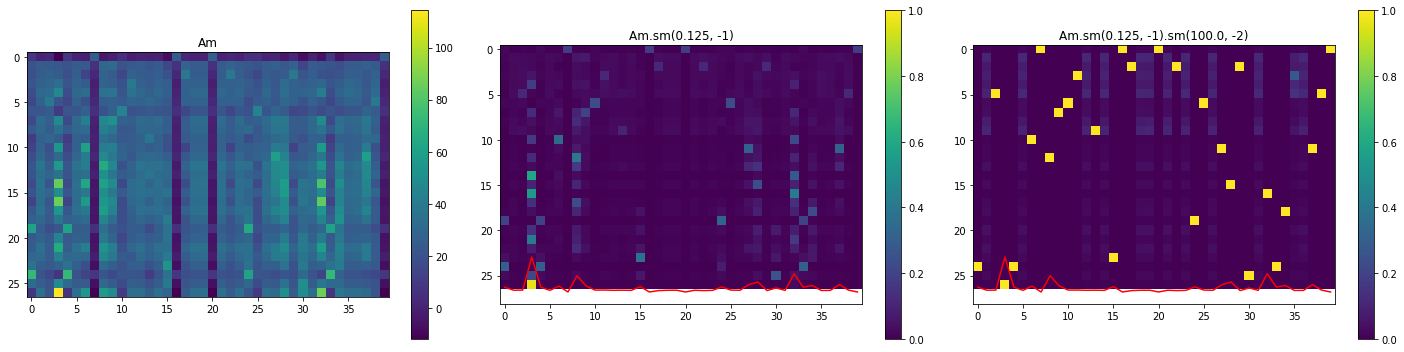

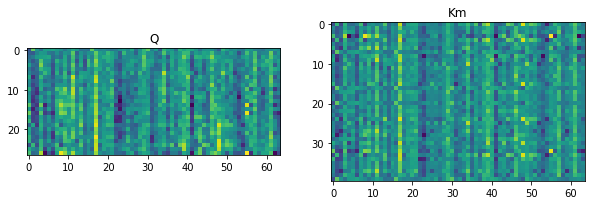

<Figure size 432x288 with 0 Axes>

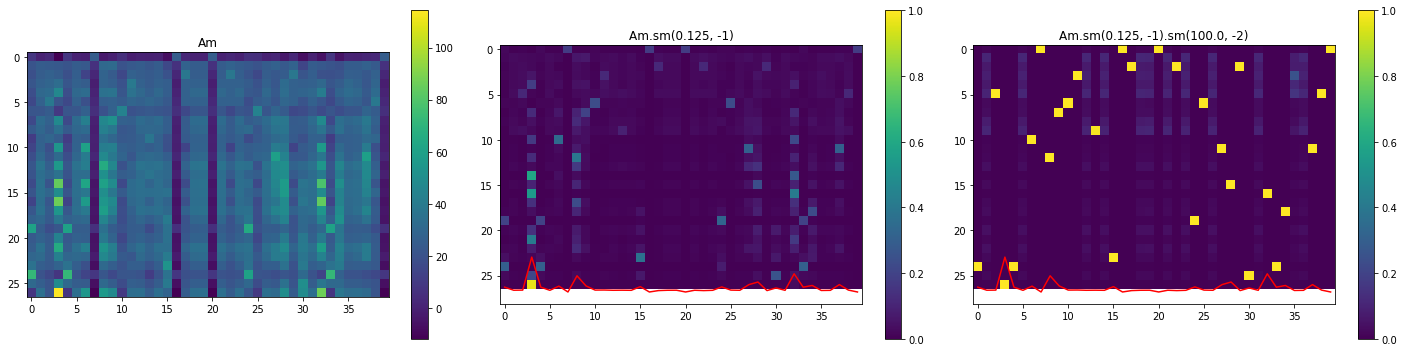

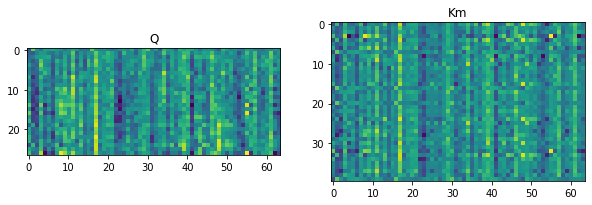

<Figure size 432x288 with 0 Axes>

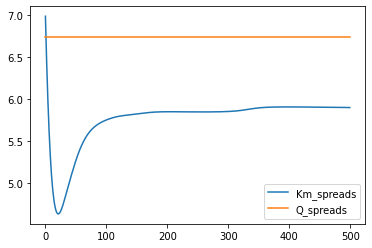

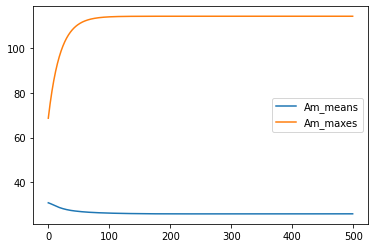

In [41]:
torch.manual_seed(10)
hm = HopfieldMemory((40, 64), alpha=0.05, use_adaptive_alpha=False, opt='sgd', lr=1.0).to(Q.device)
# hm = HopfieldMemory((40, 64), alpha=1., use_adaptive_alpha=True, opt='sgd', lr=1.0).to(Q.device)
hm.reset(1.)
hm.Km.data[:, :] = hm.Km.data[:, :]*Q.std(dim=0)+Q.mean(dim=0)
beta1, beta2 = 1/8., 100.

Am_means = []
Am_maxes = []
Km_spreads = []
Q_spreads = []

Kms = []
n_iters = 500
for i in tqdm(range(n_iters)):
    
    Km = hm.Km
    Am = Q@Km.transpose(-1, -2)
    Am_means.append(Am.mean().item())
    Am_maxes.append(Am.max().item())
    a = (Km[:, None, :] - Km[None, :, :]).norm(dim=-1)
    Km_spreads.append(a.mean().item())
    a = (Q[:, None, :] - Q[None, :, :]).norm(dim=-1)
    Q_spreads.append(a.mean().item())
    
    Kms.append(Km.clone())
    
    if i%(n_iters//10)==0:
        viz.viz_Am(Am, beta1=beta1, beta2=beta2)
        plt.tight_layout(); plt.show()
        
        viz.viz_Q_Km(Q, hm.Km)
        plt.tight_layout(); plt.show()
        
    hm.set_target_with_data(Q, O=None, dist_metric='dot', beta1=beta1, beta2=beta2, beta3=None)
    hm.step()
    
plt.plot(Km_spreads, label='Km_spreads')
plt.plot(Q_spreads, label='Q_spreads')
plt.legend()
plt.show()

plt.plot(Am_means, label='Am_means')
plt.plot(Am_maxes, label='Am_maxes')
plt.legend()
plt.show()

Kms = torch.stack(Kms)

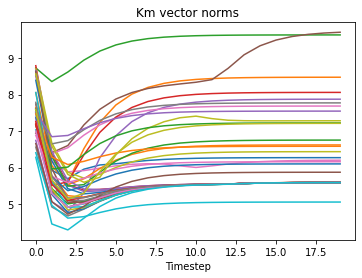

In [40]:
plt.title('Km vector norms')
plt.xlabel('Timestep')
plt.plot(Kms.norm(dim=-1).detach().cpu().numpy());

In [50]:
model.config.hidden_size

768

In [81]:
x = torch.randn(1, 20, 768).to(device)
net = model.transformer.h[0].ln_1 
y = net(x)

In [107]:
yp = (x-x.mean(dim=-1, keepdim=True))/x.std(dim=-1,keepdim=True)
# yp = yp*net.weight + net.bias

In [108]:
(yp-y).abs().max()

tensor(3.4287, device='cuda:0', grad_fn=<MaxBackward1>)

In [109]:
torch.corrcoef(torch.stack([y[0,:, 2], yp[0,:, 2]]))

tensor([[1., 1.],
        [1., 1.]], device='cuda:0', grad_fn=<ClampBackward1>)